In [1]:
import numpy as np
import torch
import torch.optim as optim
import my_utils
import argparse
from argparse import Namespace
from random import SystemRandom
import models
import matplotlib.pyplot as plt
import utils

%load_ext autoreload

/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# writing get function for ztf catalog, want to make data_obj ultimately
%autoreload
dos = my_utils.get_ztf_data()
x = dos['train_loader']
data = next(iter(x))

3398
generating 0 new sample of each example in the dataset & appending them 
 old dataset length: 2888
new dataset length: 2888
created union_x attribute of length 80142
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (2888, 3712, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
dataset shape (2888, 1, 3712, 5)


In [27]:
# if x exceeds some time constraint? clip and make it a new light curve?
# what should we do here? the longest scale of variability isssS????
tps = batch[:,0,:,0].flatten()
# data = np.array(np.squeeze(data, axis=1))

#plt.hist(tps)
#my_utils.plot(x)

def count_epochs(self, separation_std = 2, plot=False, n=0):
    print(data.shape)
    for i, lc in enumerate(self.dataset):
        print(lc.shape)
        
        dt = lc[1:,0] - lc[:-1,0] 
        print(dt)
        dt_std = np.std(dt)
        dt_mean = np.mean(dt)
        # consider observational gaps 2 stds above mean
        gaps = np.where(dt > (dt_mean + dt_std*separation_std))[0] 
        if plot == True and i == n:
            plt.scatter(lc[:,0], lc[:,1])
            for gap in gaps:
                plt.axvline(x=(lc[gap,0] + lc[gap+1,0])/2)
        self.num_epochs = gaps + 1  
        return self
    
    
    
count_epochs(data)

(8, 3712, 5)
(3712, 5)
[ 0.90234375  0.0390625  14.8984375  ...  0.          0.
  0.        ]
5


In [ ]:
# make dataset class per object then concatenate for multivariate
# otherwise make a dataset class per band! we should save normalized vs. non-normalized in diffrent object attributes 

In [2]:
import os
import pandas as pd
from dataset import DataSet
from glob import glob
fns = os.listdir('./ZTF_DR_data')

In [14]:
x = pd.read_csv(glob('./ZTF_DR_data/*iband*')[0], sep=',')

In [59]:
%autoreload

In [64]:
%autoreload

(100, 1, 200, 6)
(80, 1, 200, 6) (10, 1, 200, 6) (10, 1, 200, 6)
torch.Size([8, 1, 200, 6])


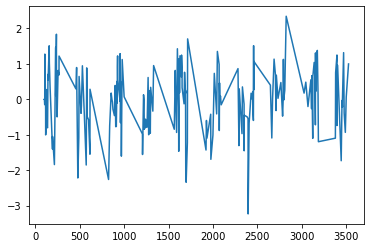

In [46]:
x = my_utils.get_synthetic_data(seed=100, uniform=True, kernel='DHO')
batch = next(iter(x['train_loader']))
print(batch.shape)

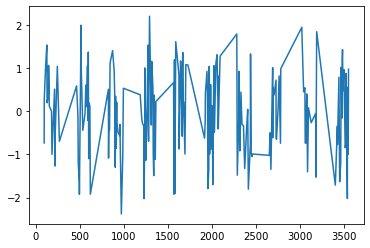

In [48]:
plt.plot(batch[0,0,:,0], batch[0,0,:,1])

In [2]:
args = Namespace(batch_size=8, bound_variance=False, const_var=False,dropout=0.19462264721791603, 
                 elbo_weight=4.108914123847402, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=32, lr=0.001, mixing='concat_and_mix', mse_weight=4.060280688730988, net='hetvae', 
                 niters=1000, norm=True, normalize_input='znorm', num_ref_points=32, rec_hidden=32, recon_loss=False, 
                 sample_tp=0.4733820088130086, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512, 
                 device='mps', data_obj='', checkpoint='',early_stopping='false', patience=50, save_at=50)


In [3]:
experiment_id = int(SystemRandom().random() * 10000000)
print(args, experiment_id)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device(args.device)

Namespace(batch_size=8, bound_variance=False, const_var=False, dropout=0.19462264721791603, elbo_weight=4.108914123847402, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=False, kl_zero=False, latent_dim=32, lr=0.001, mixing='concat_and_mix', mse_weight=4.060280688730988, net='hetvae', niters=1000, norm=True, normalize_input='znorm', num_ref_points=32, rec_hidden=32, recon_loss=False, sample_tp=0.4733820088130086, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512, device='mps', data_obj='', checkpoint='', early_stopping='false', patience=50, save_at=50) 9933309


In [4]:
%autoreload

In [5]:
if args.data_obj: # we can make the synthetic data, or we can pass the data_obj 
    pass
else:
    data_obj = my_utils.get_synthetic_data(seed=args.seed)

train_loader = data_obj["train_loader"]
test_loader = data_obj["test_loader"]
val_loader = data_obj["valid_loader"]
dim = data_obj["input_dim"]
union_tp = data_obj['union_tp']

(100, 1, 99, 6)
(80, 1, 99, 6) (10, 1, 99, 6) (10, 1, 99, 6)


In [7]:
if args.checkpoint:
    net, optimizer, args, epoch, loss = my_utils.load_checkpoint(args.checkpoint, data_obj)
    print(f'loaded checkpoint with loss: {loss}')
else:
    net = models.load_network(args, dim, union_tp)
    params = list(net.parameters())
    optimizer = optim.Adam(params, lr=args.lr)
    epoch = 1
    loss = 10000

In [10]:
def update_lr(model_size, itr, warmup):
    lr = (model_size ** -0.5) * min(itr**-0.5, itr * warmup**-0.5)
    return lr



In [12]:
model_size = utils.count_parameters(net)
itr=100
warmup =4000

update_lr(model_size,itr,warmup)

0.0003829366356242853

In [ ]:

#     net = models.load_network(args, dim, union_tp)
#     params = list(net.parameters())
#     optimizer = optim.Adam(params, lr=args.lr)


print('parameters:', utils.count_parameters(net)) # dictates learning rate
    

# stop if loss doens't decrease for how many epochs? 
best_loss = loss 
counter = 0

for itr in range(epoch, epoch+args.niters + 1):
    train_loss = 0
    train_n = 0
    avg_loglik, avg_kl, mse, mae = 0, 0, 0, 0
    if args.kl_annealing:
        wait_until_kl_inc = 10000
        if itr < wait_until_kl_inc:
            kl_coef = 0.
        else:
            kl_coef = (1 - 0.999999 ** (itr - wait_until_kl_inc))
    elif args.kl_zero:
        kl_coef = 0
    else:
        kl_coef = 1
    for train_batch in train_loader:
        batch_len = train_batch.shape[0]
        train_batch = train_batch.to(device)

        subsampled_mask = train_batch[:,:,:,-2]
        recon_mask = train_batch[:,:,:,-1]

        context_y = torch.cat((
          train_batch[:,:,:,1] * subsampled_mask, subsampled_mask
        ), 1).transpose(2,1)

        recon_context_y = torch.cat((
            train_batch[:,:,:,1] * recon_mask, recon_mask
        ), 1).transpose(2,1)

        #print(recon_context_y.shape, context_y.shape,train_batch[:, 0, :,0].shape )
        loss_info = net.compute_unsupervised_loss(
            train_batch[:, 0, :,0],
            context_y,
            train_batch[:, 0, :,0],
            recon_context_y,
            num_samples=args.k_iwae,
            beta=kl_coef,
        )
        optimizer.zero_grad()
        loss_info.composite_loss.backward()
        optimizer.step()
        train_loss += loss_info.composite_loss.item() * batch_len
        avg_loglik += loss_info.loglik * batch_len
        avg_kl += loss_info.kl * batch_len
        mse += loss_info.mse * batch_len
        mae += loss_info.mae * batch_len
        train_n += batch_len

    print(itr)
    if itr % 10 == 0:
      print(
          'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
          'mse: {:.6f}, mae: {:.6f}'.format(
              itr,
              train_loss / train_n,
              -avg_loglik / train_n,
              avg_kl / train_n,
              mse / train_n,
              mae / train_n
          )
      )
    if itr % 10 == 0:
        for loader, num_samples in [(val_loader, 5), (test_loader, 100)]:
            my_utils.evaluate_hetvae(
                net,
                dim,
                loader,
                0.5,
                shuffle=False,
                k_iwae=num_samples,
                device='mps'
            )
    ## set a learning rate scheduler?
    ## set a stopping for num_iters where there's no improvement
    if itr % args.save_at == 0 and args.save:
        torch.save({
            'args': args,
            'epoch': itr,
            'state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss / train_n,
        }, 'synth' + '_' + str(experiment_id) + '.h5')
    # could add a delta requirement to this
    if args.early_stopping:
        if best_loss > (train_loss / train_n): 
            counter += 1
        else:
            best_loss = (train_loss / train_n) 
            counter == 0

        if counter >= args.patience:
            print(f'training has not improved for {args.patience} epochs')
            torch.save({
                'args': args,
                'epoch': itr,
                'state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss / train_n,
            }, 'synth' + '_' + str(experiment_id) + '.h5')
            break

In [159]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.001463275753032352

0.003572758547163779
